#### IAU Project Phase 2 - Data Preprocessing
#### Andrej Horváth / Adam Partl
#### Share of work : 50% / 50%

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, PolynomialFeatures, QuantileTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, SelectFromModel, RFE, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

In [2]:
connections_df = pd.read_csv('data/connections.csv',delimiter='\t', on_bad_lines='skip')
processes_df = pd.read_csv('data/processes.csv',delimiter='\t', on_bad_lines='skip')

In [3]:
connections_df.head(), processes_df.head(), connections_df.columns, processes_df.columns


(                    ts                 imei  mwra  c.android.gm  c.katana  \
 0  2018-05-05 10:00:00   359043379931766452   1.0       9.41966  11.36816   
 1  2018-05-05 10:01:00  3590433799317661388   0.0      13.88490  11.33562   
 2  2018-05-05 10:02:00  3590433799317661925   1.0      12.83463  10.32837   
 3  2018-05-05 10:03:00   863033069630348065   1.0      12.01256  11.44168   
 4  2018-05-05 10:04:00  3590433799317661487   1.0       7.20744   8.65551   
 
    c.android.youtube  c.dogalize  c.android.chrome  c.updateassist  \
 0           15.79285    17.74048           4.72740         0.00468   
 1            9.28987    12.33463          12.07693         0.02109   
 2           10.42188    11.08948           8.86133         0.14300   
 3            8.05241    14.41212          14.89689         0.49394   
 4           12.87184    12.77387           8.96060         0.00351   
 
    c.UCMobile.x86  c.UCMobile.intl  c.raider  c.android.vending  
 0        34.20033         51.88892

**1.B** First we inner join the __connections__ and __processes__ tables based on ts and imei to get a single table with all the information for a single time and device.

In [4]:
merged_df = pd.merge(connections_df, processes_df, on=['ts', 'imei'], how='inner')

In [5]:
merged_df.head()

,ts,imei,mwra_x,c.android.gm,c.katana,c.android.youtube,c.dogalize,c.android.chrome,c.updateassist,c.UCMobile.x86,...,p.browser.provider,p.process.gapps,p.dogalize,p.gms.persistent,p.android.vending,p.android.defcontainer,p.simulator,p.notifier,p.inputmethod.latin,p.katana
0,2018-05-05 10:00:00,359043379931766452,1.0,9.41966,11.36816,15.79285,17.74048,4.72740,0.00468,34.20033,...,58.70704,99.14511,30.15922,46.80586,39.47757,71.04335,18.07725,6.10710,93.51355,43.54900
1,2018-05-05 10:01:00,3590433799317661388,0.0,13.88490,11.33562,9.28987,12.33463,12.07693,0.02109,39.88012,...,70.55709,75.05935,17.47487,54.87990,18.93862,80.71500,42.57503,90.27154,98.06205,13.16659
2,2018-05-05 10:02:00,3590433799317661925,1.0,12.83463,10.32837,10.42188,11.08948,8.86133,0.14300,41.54384,...,35.73376,90.65073,19.59184,68.71474,48.71668,2.84559,97.58948,69.74676,87.89989,87.82491
3,2018-05-05 10:03:00,863033069630348065,1.0,12.01256,11.44168,8.05241,14.41212,14.89689,0.49394,63.92628,...,60.82898,24.18521,73.16847,56.50602,90.77773,13.32702,87.50827,64.63028,49.89641,66.25061
4,2018-05-05 10:04:00,3590433799317661487,1.0,7.20744,8.65551,12.87184,12.77387,8.96060,0.00351,61.11501,...,49.08519,56.95855,47.59887,28.71102,87.78758,75.88927,69.74888,78.87172,22.58957,44.97264


In [6]:
differences = merged_df[merged_df['mwra_x'] != merged_df['mwra_y']]
differences

,ts,imei,mwra_x,c.android.gm,c.katana,c.android.youtube,c.dogalize,c.android.chrome,c.updateassist,c.UCMobile.x86,...,p.browser.provider,p.process.gapps,p.dogalize,p.gms.persistent,p.android.vending,p.android.defcontainer,p.simulator,p.notifier,p.inputmethod.latin,p.katana


Since both tables contained the mwra column we drop one and rename the other back to mwra.

In [7]:
merged_df = merged_df.drop(columns=['mwra_y']).rename(columns={'mwra_x': 'mwra'})

We separate features and the target variable. We also drop the ts and imei columns since they are irelevant to the measurements.

In [8]:
X = merged_df.drop(columns=['mwra', 'ts', 'imei'])
y = merged_df['mwra']

**1.A** We split the table into training and testing data with an 80:20 ratio.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12351, 30), (3088, 30), (12351,), (3088,))

**1.B** Before beginning testing we will handle outliers

In [11]:
def handle_outliers(df, lower_quantile, upper_quantile):
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    ndf = df.copy()
    for col in numeric_columns:
        if col == 'mwra' or col == 'imei':
            continue
        Q1 = df[col].quantile(lower_quantile)
        Q2 = df[col].quantile(upper_quantile)
        IQR = Q2 - Q1
        lower_bound = df[col].quantile(lower_quantile) - 1.5 * IQR
        upper_bound = df[col].quantile(upper_quantile) + 1.5 * IQR
        
        mean_value = ndf[col].mean()
        ndf[col] = np.where(ndf[col] < lower_bound, mean_value, 
                            np.where(ndf[col] > upper_bound, mean_value, ndf[col]))
    
    return ndf

X_train = handle_outliers(X_train,0.3,0.7)

We use the replacement method of error handling as it turned out better in the previous phase of the project. We use 0.3 and 0.7 quantiles as bounds for outliers.

### Now that we have successfully prepared the data and split them into training and testing sets, we can proceed to find the best methods for feature selection, scaling and transforming that are going to be used then in the final pipeline.
### Due to us testing multiple combinations to find the best one, the next code block has a runtime of about 5 minutes

In this code block, we iteratively loop through different pipeline settings. We are doing a part of task **1.B - treating missing values**, then **1.C - scaling (Standard, MinMax, Robust) and transformers(Power, Polynomial and Quantile), also a Simple Imputer**
We are also going through different **2.A - feature selection methods, where we test f_classif - which is computing the ANOVA F-value, mutual_info_classif - which computes mutual information between two variables, Random Forest and Recursive Feature Elimination with Logistic Regression**
Tasks  2.B and 2.C are done at the end of this notebook and are done on the final pipeline.

In [12]:
# Define which columns are numerical and which are categorical
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

# Categorical pipeline: imputation, encoding
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),    # Handle missing values
    ('encoder', OneHotEncoder(handle_unknown='ignore'))      # Encoding technique
])

# Define pipelines with multiple transformations for numerical features
num_pipeline_alternatives = {
    'standard+power': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('power', PowerTransformer())
    ]),
    'minmax+polynomial': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler()),
        ('poly', PolynomialFeatures(degree=2))
    ]),
    'robust+quantile': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler()),
        ('quantile', QuantileTransformer())
    ])
}

# Feature selection options
feature_selection_alternatives = {
    'f_classif': SelectKBest(score_func=f_classif, k=10),
    'mutual_info': SelectKBest(score_func=mutual_info_classif, k=10),
    'from_model_rf': SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=78)),
    'rfe_lr': RFE(estimator=LogisticRegression(max_iter=200), n_features_to_select=10)
}

# Testing different combinations of scaling, transformations, and feature selection
for num_pipeline_name, num_pipeline in num_pipeline_alternatives.items():
    for fs_name, feature_selection in feature_selection_alternatives.items():
        try:
            # Define the full pipeline
            full_pipeline = Pipeline([
                ('preprocessor', ColumnTransformer([
                    ('num', num_pipeline, num_features),
                    ('cat', cat_pipeline, cat_features)
                ])),
                ('feature_selection', feature_selection),
                ('classifier', LogisticRegression(max_iter=200))
            ])

            # Fit and evaluate the pipeline
            full_pipeline.fit(X_train, y_train)
            train_score = full_pipeline.score(X_train, y_train)
            test_score = full_pipeline.score(X_test, y_test)
            print(f"Pipeline with {num_pipeline_name} and {fs_name} selection: Train Score = {train_score}, Test Score = {test_score}")

        except Exception as e:
            print(f"Error with pipeline {num_pipeline_name} and {fs_name} selection: {e}")

Pipeline with standard+power and f_classif selection: Train Score = 0.8966075621407174, Test Score = 0.9183937823834197
Pipeline with standard+power and mutual_info selection: Train Score = 0.8966075621407174, Test Score = 0.9183937823834197
Pipeline with standard+power and from_model_rf selection: Train Score = 0.8883491215286211, Test Score = 0.9102979274611399
Pipeline with standard+power and rfe_lr selection: Train Score = 0.8966075621407174, Test Score = 0.9183937823834197


C:\Users\partl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\partl\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Pipeline with minmax+polynomial and f_classif selection: Train Score = 0.8873775402801393, Test Score = 0.9080310880829016
Pipeline with minmax+polynomial and mutual_info selection: Train Score = 0.8645453809408145, Test Score = 0.8698186528497409
Pipeline with minmax+polynomial and from_model_rf selection: Train Score = 0.9051898631689742, Test Score = 0.8623704663212435
Pipeline with minmax+polynomial and rfe_lr selection: Train Score = 0.8978220387013197, Test Score = 0.9200129533678757
Pipeline with robust+quantile and f_classif selection: Train Score = 0.8966075621407174, Test Score = 0.915479274611399
Pipeline with robust+quantile and mutual_info selection: Train Score = 0.896445631932637, Test Score = 0.9161269430051814
Pipeline with robust+quantile and from_model_rf selection: Train Score = 0.8885920168407416, Test Score = 0.9106217616580311
Pipeline with robust+quantile and rfe_lr selection: Train Score = 0.8965265970366771, Test Score = 0.9158031088082902


**1.D** Based on the results of this testing, we can see that the best performing combination for the pipeline is to use **Simple Imputer** with **Min Max Scaler** and **Polynomial Transformer** . Futhermore the feature selection method that seems to be the best for the setting of this pipeline is **Recursive Feature Elimination (RFE) with Logistic Regression**, having the highest accuracy scores.
Next we will proceed with some fine-tuning to try to get even better accuracy and base the final pipeline on that.

### Final Pipeline

Here we create the final pipeline, using the settings from above, completing tasks **3.A and 3.B**

In [13]:
# Define which columns are numerical and which are categorical
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

# Numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=2)),
])

# Categorical pipeline
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OneHotEncoder(handle_unknown='ignore')),    
])

# Combine pipelines
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Create a full pipeline with the preprocessor and feature selection
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', RFE(estimator=LogisticRegression(max_iter=200), n_features_to_select=10)),  # Feature selection
    ('classifier', LogisticRegression(max_iter=200))
])

# Fit the pipeline to the training data
full_pipeline.fit(X_train, y_train)

# Evaluate the model
train_score = full_pipeline.score(X_train, y_train)
test_predictions = full_pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)

# Save the pipeline
pipeline_filename = 'pipeline.pkl'
joblib.dump(full_pipeline, pipeline_filename)

train_score, test_accuracy, pipeline_filename

(0.8978220387013197, 0.9200129533678757, 'pipeline.pkl')

Following are some additional tests, that we do to check for overfitting and underfitting. (cross-validation, classification report, ROC and AUC scores)

In [14]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(full_pipeline, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Mean Accuracy:", cv_scores.mean())

Cross-Validation Mean Accuracy: 0.8976602106704984


In [15]:
from sklearn.metrics import classification_report

train_predictions = full_pipeline.predict(X_train)
print("Training Classification Report:\n", classification_report(y_train, train_predictions))

Training Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.82      0.86      4607
         1.0       0.90      0.94      0.92      7744

    accuracy                           0.90     12351
   macro avg       0.90      0.88      0.89     12351
weighted avg       0.90      0.90      0.90     12351


In [16]:
test_predictions = full_pipeline.predict(X_test)
print("Test Classification Report:\n", classification_report(y_test, test_predictions))

Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.86      0.89      1139
         1.0       0.92      0.95      0.94      1949

    accuracy                           0.92      3088
   macro avg       0.92      0.91      0.91      3088
weighted avg       0.92      0.92      0.92      3088


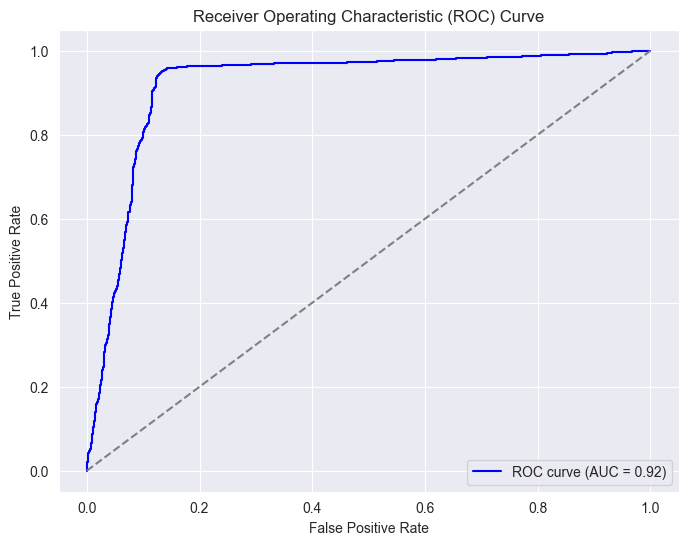

In [17]:
y_test_proba = full_pipeline.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc_score = roc_auc_score(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**2.B, 2.C** Here we can see the features selected for the final pipeline. We used Recursive Feature Elimination (RFE) with Logistic Regression, since while testing, this method was yielding the best results. We also extracted the features that were selected by the model and displayed them ordered by importance.

In [21]:
feature_selector = full_pipeline.named_steps['feature_selection']
selected_model = feature_selector.estimator_ 

# Extract feature importances from the model
importances = abs(selected_model.coef_).flatten()
# Get feature names after preprocessing
preprocessed_features = full_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Only keep names of the features selected by RFE
selected_features = [preprocessed_features[i] for i in range(len(preprocessed_features)) if feature_selector.support_[i]]

feature_importances = sorted(zip(selected_features, importances), key=lambda x: x[1], reverse=True)

print("Top 10 most important features:")
for feature, importance in feature_importances:
    print(f"{feature}: {importance}")

Top 10 most important features:
num__c.katana p.android.gm: 5.775382679854592
num__p.android.packageinstaller p.android.gm: 5.0697061048058965
num__c.katana p.android.packageinstaller: 4.016750502923513
num__c.android.gm: 3.941312253976351
num__c.android.youtube c.dogalize: 3.1094822076450477
num__c.android.youtube p.system: 2.9448197516421373
num__c.android.chrome p.android.externalstorage: 2.5163047861183583
num__c.dogalize p.android.documentsui: 2.51174844227257
num__c.android.chrome p.system: 2.2572744140850594
num__p.android.documentsui p.system: 2.048698695513872
